In [5]:
import numpy as np
# Define activation functions and their back propagation: sigmoid, relu, and softmax

def relu(z):
    return np.maximum(0, z)


def relu_backward(da, z):
    dz = np.array(da, copy=True)
    dz[z <= 0] = 0
    return dz


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def softmax_backward(dA, Z):
    return dA


# Initialize all the parameters of the neural network
def init_layers(nn_layers, seed=100):
    # nn_layer contains the structure setting of the neural network
    # seed is to ensure the same random initialization
    np.random.seed(seed)
    
    param_cache = {}

    for idx, layer in enumerate(nn_layers):
        layer_idx = idx + 1

        layer_input_size = layer["size_in"]
        layer_output_size = layer["size_out"]

        param_cache['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) *np.sqrt(2/layer_output_size) 
        param_cache['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * np.sqrt(2/layer_output_size)
        
        
    return param_cache


# Functions for forward and backward propagations
def forward_one(A_prev, W_curr, b_curr, act_func,para):
    # A_prev is the output of last layer after activation function
    # W_curr and b_curr are the weight matrix and bias of the current layer
    # act_func is the type of activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr

    if act_func is "relu":
        activation_func = relu
        if para['mode']=='train':
            u1=np.random.rand(Z_curr.shape[0],Z_curr.shape[1])
            u1=np.where(u1<0.8,1,0)
            u1=u1/0.8
            Z_curra=activation_func(Z_curr)*u1
            return Z_curra, Z_curr
        else:
            return activation_func(Z_curr),Z_curr
        
    elif act_func is "softmax":
        activation_func = softmax
        return activation_func(Z_curr), Z_curr

    else:
        raise Exception('Non-supported activation function')
    
def forward_all(X, param_cache, nn_layers,para):
    # X is the input of the network: feature x sample
    # param_cache contains all the weight and bias
    layer_out_cache = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_layers):
        layer_idx = idx + 1
        A_prev = A_curr

        activ_function_curr = layer["act_func"]
        W_curr = param_cache["W" + str(layer_idx)]
        b_curr = param_cache["b" + str(layer_idx)]

        A_curr, Z_curr = forward_one(A_prev, W_curr, b_curr, activ_function_curr,para)
        
        layer_out_cache["A" + str(idx)] = A_prev
        layer_out_cache["Z" + str(layer_idx)] = Z_curr

    return A_curr, layer_out_cache

def backward_one(dA_curr, W_curr, b_curr, Z_curr, A_prev, act_func="relu"):
    # dA_curr is the derivate w.r.t. the current activation function

    m = A_prev.shape[1]

    if act_func is "relu":
        backward_activation_func = relu_backward
    elif act_func is "softmax":
        backward_activation_func = softmax_backward
    else:
        raise Exception('No supported activation function')
        

    dZ_curr = backward_activation_func(dA_curr, Z_curr)

    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr


def backward_all(Y_hat, Y, memory, param_cache, nn_layers,lamda):
    # Y_hat is the output of the whole network
    # Y is the real label

    grads_values = {}

    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)

    # initiation of gradient descent algorithm
    
    dA_prev = Y_hat - Y
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_layers))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["act_func"]

        dA_curr = dA_prev

        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]

        
        W_curr = param_cache["W" + str(layer_idx_curr)]
        b_curr = param_cache["b" + str(layer_idx_curr)]
        
        
        dA_prev, dW_curr, db_curr = backward_one(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr+2*lamda* W_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr


    return grads_values


# Update the parameters: W and b
def update_param(param_cache, grads_values, nn_layers, lr):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_layers, 1):
        
        param_cache["W" + str(layer_idx)] -= lr * grads_values["dW" + str(layer_idx)]
        param_cache["b" + str(layer_idx)] -= lr * grads_values["db" + str(layer_idx)]

    return param_cache


# Calculate the value of loss function
def compute_loss(Y, Y_hat,lamda,para):
    
    L_sum = np.sum(Y* np.log(Y_hat))
    L = -(1/Y.shape[1]) * L_sum
    for i in range(len(para)//4):
        L+=np.sum((para["W" + str(i+1)])**2)*lamda
    return L


In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    #remember to transpose inputs when using this
    #assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        return inputs[excerpt], targets[excerpt]

def compute_accuracy(H,y):
   
    k = np.argmax(H, axis=0)
    acc=0
    for i in range(len(y)):
        if k[i]==y[i]:
            acc+=1
            
    acc=acc/len(y)
    return acc

In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def load_data(directory):
    
    # load data as a normalized way
    
    C=10  #number of classes
    X = LoadBatch(directory)[b'data'].transpose()
    # normalize the raw input data
    X_mean = X.mean(axis=1).reshape(-1,1)
    X_std = X.std(axis=1).reshape(-1,1)
    X = (X-X_mean)/X_std
    y = np.array(LoadBatch(directory)[b'labels'])
    #one-hot representation of the label for each image
    Y = np.eye(C, dtype=int)[y].transpose()
    return X, Y, y

def LoadBatch(filename):
    """ Copied from the dataset website """
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Xtr, Ytr, ytr = load_data("/Users/imogen/Desktop/DD2424/Assignment1/cifar-10-batches-py/data_batch_1")
X2, Y2, y2 = load_data("/Users/imogen/Desktop/DD2424/Assignment1/cifar-10-batches-py/data_batch_2")
X3, Y3, y3 = load_data("/Users/imogen/Desktop/DD2424/Assignment1/cifar-10-batches-py/data_batch_3")
X4, Y4, y4 = load_data("/Users/imogen/Desktop/DD2424/Assignment1/cifar-10-batches-py/data_batch_4")
X5, Y5, y5 = load_data("/Users/imogen/Desktop/DD2424/Assignment1/cifar-10-batches-py/data_batch_5")
Xtr=np.hstack((Xtr,X2,X3,X4,X5))
Ytr=np.hstack((Ytr,Y2,Y3,Y4,Y5))
ytr=np.hstack((ytr,y2,y3,y4,y5))
Xva=Xtr[0:,0:5000]
Yva=Ytr[0:,0:5000]
yva=ytr[0:5000]
Xtr=Xtr[0:,5000:]
Ytr=Ytr[0:,5000:]
ytr=ytr[5000:]
Xte, Yte, yte = load_data("/Users/imogen/Desktop/DD2424/Assignment1/cifar-10-batches-py/test_batch")

In [12]:
class k_layer_classifier():
    
    def __init__(self, nn_layers, param_cache,bn_param,lamda=0, n_epochs=40, n_batch=100, etamin=1e-5,etamax=0.1,k=2):
        self.para=param_cache
        self.nn_layers=nn_layers
        self.bn_param=bn_param
        self.lamda=lamda
        self.n_batch=n_batch
        self.n_epochs=n_epochs
        self.etamin =etamin
        self.etamax=etamax
        self.eta = self.etamin
        self.k=k
    
    def fit(self,Xtr, Ytr, ytr, Xva, Yva, yva):
        
        trainingloss=[]
        validationloss=[]
        trainingaccuracy=[]
        validationaccuracy=[]
        lr=[]
        updatestep=0
        acc=[]
        for i in range(self.n_epochs):

            Xtr, ytr=iterate_minibatches(Xtr.T, ytr, Xtr.shape[1], shuffle=True)
            Xtr=Xtr.T
            Ytr = np.eye(10, dtype=int)[ytr].transpose()
            

            batch_size=Xtr.shape[1]//self.n_batch
            for j in range(batch_size):
                
                x_mini_batch = Xtr.T[j*self.n_batch:(j+1)*self.n_batch]
                Y_mini_batch = Ytr.T[j*self.n_batch:(j+1)*self.n_batch]
                ymini_batch = ytr.T[j*self.n_batch:(j+1)*self.n_batch]
                
                
                Y_hat, cache1 = forward_all(x_mini_batch.T, self.para, self.nn_layers,self.bn_param)
                grads_values = backward_all(Y_hat, Y_mini_batch.T, cache1, self.para, self.nn_layers,self.lamda)
            
#                 ns=self.k*batch_size
#                 if i%(2*self.k)<self.k:
#                      self.eta =self.etamin + (j+(i%self.k)*batch_size)*(self.etamax-self.etamin)/ns
#                 else:
#                     self.eta =self.etamax - (j+(i%self.k)*batch_size)*(self.etamax-self.etamin)/ns
                self.eta=self.eta*1.004
                param_cache = update_param(self.para, grads_values, self.nn_layers, self.eta)
                lr.append(self.eta)
                accnow=self.predict(Xte, Yte, yte)
                acc.append(accnow)
       
           
            
#             Y_hat2,_=forward_all(Xtr,self.para, self.nn_layers,self.bn_param)
#             l=compute_loss(Ytr, Y_hat2,self.lamda,self.para)
#             acc=compute_accuracy(Y_hat2,ytr)
#             trainingloss.append(l)
#             trainingaccuracy.append(acc)
#             print("the",format(i),"epoch for training data,"," the loss is", l, "the accuracy is ",acc)

            
#             Y_hat2,_=forward_all(Xva,self.para, self.nn_layers,self.bn_param)
#             l=compute_loss(Yva, Y_hat2,self.lamda,self.para)
#             acc=compute_accuracy(Y_hat2,yva)
#             validationloss.append(l)
#             validationaccuracy.append(acc)
#             print("the",format(i),"epoch for validation data,"," the loss is", l, "the accuracy is ",acc)

         
        plt.plot(lr, acc )
        plt.xlabel("learning rate")
        plt.ylabel("test accuracy")
        plt.legend()
        plt.title('LR range test') 
        plt.show()
            
#         x = range(1,self.n_epochs+1)    
#         plt.plot(x, trainingloss,  label = "training loss" )
#         plt.plot(x, validationloss, label = "validation loss" )
#         plt.xlabel("epoch")
#         plt.ylabel("loss")
#         plt.legend()
#         plt.title('training and validation loss') 
#         plt.show()
        
#         x = range(1,self.n_epochs+1)    
#         plt.plot(x, trainingaccuracy,  label = "training accuracy" )
#         plt.plot(x, validationaccuracy, label = "validation accuracy" )
#         plt.xlabel("epoch")
#         plt.ylabel("accuracy")
#         plt.legend()
#         plt.title('training and validation accuracy') 
#         plt.show()
        
        
     
    def predict(self, Xte, Yte, yte):
        self.bn_param['mode']='test'
        Y_hat,_=forward_all(Xte,self.para, self.nn_layers, self.bn_param)
        l=compute_loss(Yte, Y_hat,self.lamda,self.para)
        acc=compute_accuracy(Y_hat,yte)
#         print("the loss is", l, "the accuracy is ",acc)
        return acc

/Users/imogen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in multiply
/Users/imogen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/imogen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: divide by zero encountered in log
/Users/imogen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


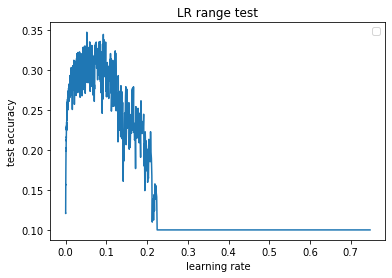

0.1

In [13]:
nn_layers = [
    {"size_in": 3072, "size_out": 100, "act_func": "relu"},
    {"size_in": 100, "size_out": 10, "act_func": "softmax"}
            ]
param_cache = init_layers(nn_layers)
param = {"mode":"train"}
c=k_layer_classifier(nn_layers, param_cache,param,lamda=10**(-2.82638), n_epochs=5, n_batch=100, etamin=1e-5,etamax=0.1,k=7)
c.fit(Xtr, Ytr, ytr, Xva, Yva, yva)

/Users/imogen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in multiply
/Users/imogen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/imogen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: RuntimeWarning: divide by zero encountered in log
/Users/imogen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


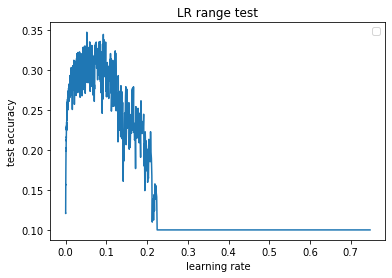

In [14]:
nn_layers = [
    {"size_in": 3072, "size_out": 100, "act_func": "relu"},
    {"size_in": 100, "size_out": 10, "act_func": "softmax"}
            ]
param_cache = init_layers(nn_layers)
param = {"mode":"train"}
c=k_layer_classifier(nn_layers, param_cache,param,lamda=10**(-2.82638), n_epochs=5, n_batch=100, etamin=1e-5,etamax=0.1,k=7)
c.fit(Xtr, Ytr, ytr, Xva, Yva, yva)

No handles with labels found to put in legend.


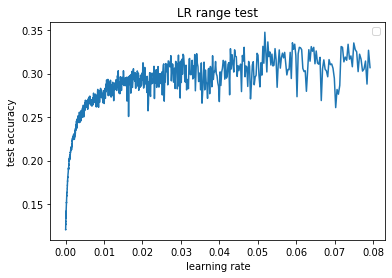

In [17]:
nn_layers = [
    {"size_in": 3072, "size_out": 100, "act_func": "relu"},
    {"size_in": 100, "size_out": 10, "act_func": "softmax"}
            ]
param_cache = init_layers(nn_layers)
param = {"mode":"train"}
c=k_layer_classifier(nn_layers, param_cache,param,lamda=10**(-2.82638), n_epochs=4, n_batch=100, etamin=1e-5,etamax=0.1,k=7)
c.fit(Xtr, Ytr, ytr, Xva, Yva, yva)

No handles with labels found to put in legend.


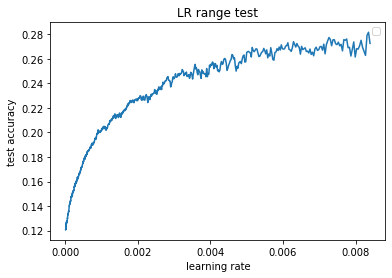

In [16]:
nn_layers = [
    {"size_in": 3072, "size_out": 100, "act_func": "relu"},
    {"size_in": 100, "size_out": 10, "act_func": "softmax"}
            ]
param_cache = init_layers(nn_layers)
param = {"mode":"train"}
c=k_layer_classifier(nn_layers, param_cache,param,lamda=10**(-2.82638), n_epochs=3, n_batch=100, etamin=1e-5,etamax=0.1,k=7)
c.fit(Xtr, Ytr, ytr, Xva, Yva, yva)

In [ ]:
nn_layers = [
    {"size_in": 3072, "size_out": 100, "act_func": "relu"},
    {"size_in": 100, "size_out": 10, "act_func": "softmax"}
            ]
param_cache = init_layers(nn_layers)
param = {"mode":"train"}
c=k_layer_classifier(nn_layers, param_cache,param,lamda=10**(-2.82638), n_epochs=5, n_batch=100, etamin=1e-5,etamax=0.1,k=7)
c.fit(Xtr, Ytr, ytr, Xva, Yva, yva)
c.predict(Xte, Yte, yte)

the 0 epoch for training data,  the loss is 15.288403477246527 the accuracy is  0.2974222222222222
the 0 epoch for validation data,  the loss is 15.636897450662616 the accuracy is  0.2764
the 1 epoch for training data,  the loss is 10.653489180968247 the accuracy is  0.35246666666666665
the 1 epoch for validation data,  the loss is 10.89205886152486 the accuracy is  0.318
the 2 epoch for training data,  the loss is 9.25232536156595 the accuracy is  0.39926666666666666
the 2 epoch for validation data,  the loss is 9.353646194708025 the accuracy is  0.371
the 3 epoch for training data,  the loss is 8.258690786275768 the accuracy is  0.4065111111111111
the 3 epoch for validation data,  the loss is 8.350446067970118 the accuracy is  0.3828
the 4 epoch for training data,  the loss is 7.140831301274033 the accuracy is  0.41746666666666665
the 4 epoch for validation data,  the loss is 7.270212383233533 the accuracy is  0.383
the 5 epoch for training data,  the loss is 6.020153881762402 the ac

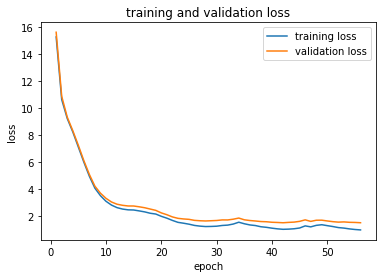

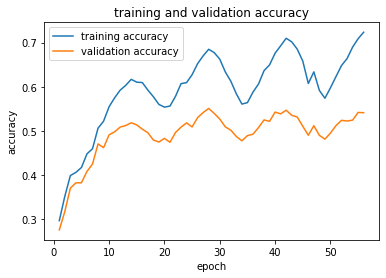

the loss is 1.518705545858973 the accuracy is  0.5324


In [62]:
nn_layers = [
    {"size_in": 3072, "size_out": 75, "act_func": "relu"},
    {"size_in": 75, "size_out": 10, "act_func": "softmax"}
            ]
param_cache = init_layers(nn_layers)
bn_param = {"mode":"train"}
c=k_layer_classifier(nn_layers, param_cache,bn_param,lamda=10**(-2.82638), n_epochs=56, n_batch=100, etamin=1e-5,etamax=0.1,k=7)
c.fit(Xtr, Ytr, ytr, Xva, Yva, yva)
c.predict(Xte, Yte, yte)

the 0 epoch for training data,  the loss is 15.775345196880465 the accuracy is  0.30417777777777777
the 0 epoch for validation data,  the loss is 16.234095443707993 the accuracy is  0.2966
the 1 epoch for training data,  the loss is 11.182294723836815 the accuracy is  0.36666666666666664
the 1 epoch for validation data,  the loss is 11.556830044657175 the accuracy is  0.3318
the 2 epoch for training data,  the loss is 9.151471377483334 the accuracy is  0.43393333333333334
the 2 epoch for validation data,  the loss is 9.310531588166851 the accuracy is  0.3898
the 3 epoch for training data,  the loss is 8.218295691613836 the accuracy is  0.42766666666666664
the 3 epoch for validation data,  the loss is 8.355724713468266 the accuracy is  0.3928
the 4 epoch for training data,  the loss is 7.057370221022175 the accuracy is  0.4564
the 4 epoch for validation data,  the loss is 7.2060227980184735 the accuracy is  0.4188
the 5 epoch for training data,  the loss is 5.9981538526856895 the accura

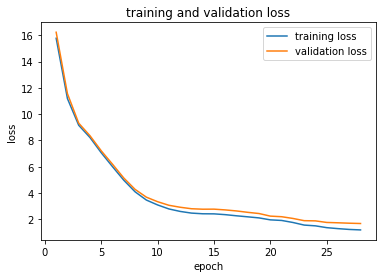

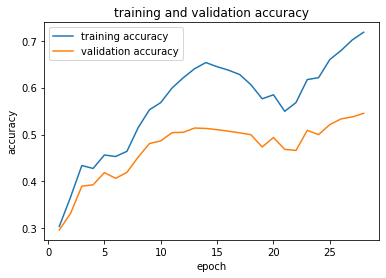

the loss is 1.6841203559547016 the accuracy is  0.5338


In [63]:
nn_layers = [
    {"size_in": 3072, "size_out": 100, "act_func": "relu"},
    {"size_in": 100, "size_out": 10, "act_func": "softmax"}
            ]
param_cache = init_layers(nn_layers)
bn_param = {"mode":"train"}
c=k_layer_classifier(nn_layers, param_cache,bn_param,lamda=10**(-2.82638), n_epochs=28, n_batch=100, etamin=1e-5,etamax=0.1,k=7)
c.fit(Xtr, Ytr, ytr, Xva, Yva, yva)
c.predict(Xte, Yte, yte)

the 0 epoch for training data,  the loss is 15.775345196880465 the accuracy is  0.30417777777777777
the 0 epoch for validation data,  the loss is 16.234095443707993 the accuracy is  0.2966
the 1 epoch for training data,  the loss is 11.182294723836815 the accuracy is  0.36666666666666664
the 1 epoch for validation data,  the loss is 11.556830044657175 the accuracy is  0.3318
the 2 epoch for training data,  the loss is 9.151471377483334 the accuracy is  0.43393333333333334
the 2 epoch for validation data,  the loss is 9.310531588166851 the accuracy is  0.3898
the 3 epoch for training data,  the loss is 8.218295691613836 the accuracy is  0.42766666666666664
the 3 epoch for validation data,  the loss is 8.355724713468266 the accuracy is  0.3928
the 4 epoch for training data,  the loss is 7.057370221022175 the accuracy is  0.4564
the 4 epoch for validation data,  the loss is 7.2060227980184735 the accuracy is  0.4188
the 5 epoch for training data,  the loss is 5.9981538526856895 the accura

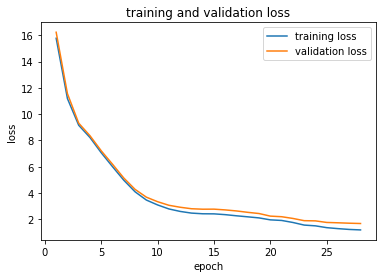

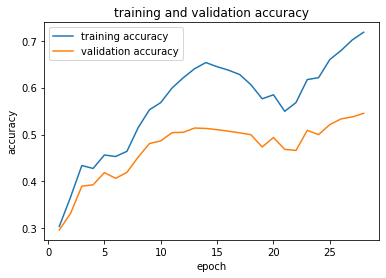

the loss is 1.6841203559547016 the accuracy is  0.5338


In [64]:
layers = [
    {"size_in": 3072, "size_out": 300, "act_func": "relu"},
    {"size_in": 300, "size_out": 10, "act_func": "softmax"}
            ]
param_cache = init_layers(nn_layers)
bn_param = {"mode":"train"}
c=k_layer_classifier(nn_layers, param_cache,bn_param,lamda=10**(-2.82638), n_epochs=28, n_batch=100, etamin=1e-5,etamax=0.1,k=7)
c.fit(Xtr, Ytr, ytr, Xva, Yva, yva)
c.predict(Xte, Yte, yte)